In [79]:
import numpy as np
import pandas as pd
import yfinance as yf
import os
from pymoo.core.problem import ElementwiseProblem
from pymoo.core.repair import Repair
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.optimize import minimize
from pymoo.termination import get_termination
from pymoo.operators.crossover.pntx import TwoPointCrossover
from pymoo.visualization.scatter import Scatter

In [80]:
start_date = '2020-01-01'
end_date = '2020-12-31'
initial_value = 100000

adj_close_df = pd.read_csv('relatorios/preco-renda-fixa.csv', index_col=0, parse_dates=True)

rebalance_dates = pd.DatetimeIndex(pd.read_csv('relatorios/datas-fim-de-mes.txt', header=None)[0])
rebalance_dates = rebalance_dates[(rebalance_dates>=start_date) & (rebalance_dates <= end_date)]

rebalance_dates

portfolio_value = initial_value
portfolio_values = []
dates = []
weights_history = []

In [81]:
class PortfolioProblem(ElementwiseProblem):
    def __init__(self, mu, cov, **kwargs):
        super().__init__(n_var=len(mu), n_obj=2, xl=0.0, xu=1.0, **kwargs)
        self.mu = mu
        self.cov = cov
    def _evaluate(self, x, out, *args, **kwargs):
        expected_return = self.mu.T @ x
        risk = x.T @ self.cov @ x
        out["F"] = [risk, -expected_return]

class SumToOneRepair(Repair):
    def _do(self, problem, X, **kwargs):
        return X / np.sum(X, axis=1, keepdims=True)

In [82]:
returns = np.log(adj_close_df / adj_close_df.shift(1)).dropna()

mu = returns.mean() * 252
cov = returns.cov() * 252

problem = PortfolioProblem(mu, cov)
algorithm = NSGA2(pop_size=200, repair=SumToOneRepair())
termination = get_termination("n_gen", 500)

res = minimize(problem,
               algorithm,
               termination,
               seed=1,
               save_history=True,
               verbose=True)

n_gen  |  n_eval  | n_nds  |      eps      |   indicator  
     1 |      200 |     12 |             - |             -
     2 |      400 |     13 |  0.1074626021 |         ideal
     3 |      600 |     16 |  0.0508516235 |         ideal
     4 |      800 |     20 |  0.3319164787 |         ideal
     5 |     1000 |     23 |  0.0242214364 |             f
     6 |     1200 |     17 |  0.3818747122 |         ideal
     7 |     1400 |     23 |  0.0406014584 |         ideal
     8 |     1600 |     28 |  0.0324761277 |             f
     9 |     1800 |     34 |  0.0086303339 |         ideal
    10 |     2000 |     31 |  0.0268199072 |         ideal
    11 |     2200 |     27 |  0.0664125030 |         ideal
    12 |     2400 |     36 |  0.0346661663 |         ideal
    13 |     2600 |     39 |  0.0767670097 |         ideal
    14 |     2800 |     36 |  0.0100268873 |         ideal
    15 |     3000 |     43 |  0.0324004431 |         ideal
    16 |     3200 |     54 |  0.0038172750 |         ide

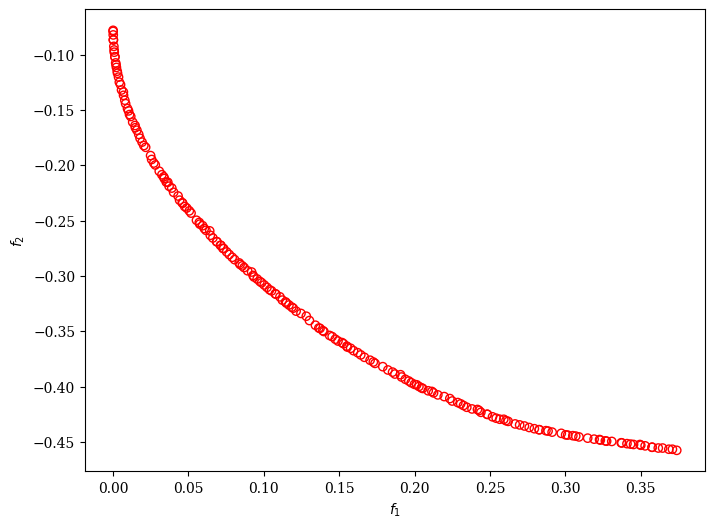

In [83]:
plot = Scatter()
plot.add(problem.pareto_front(), plot_type="line", color="black", alpha=0.7)
plot.add(res.F, facecolor="none", edgecolor="red")
plot.show()

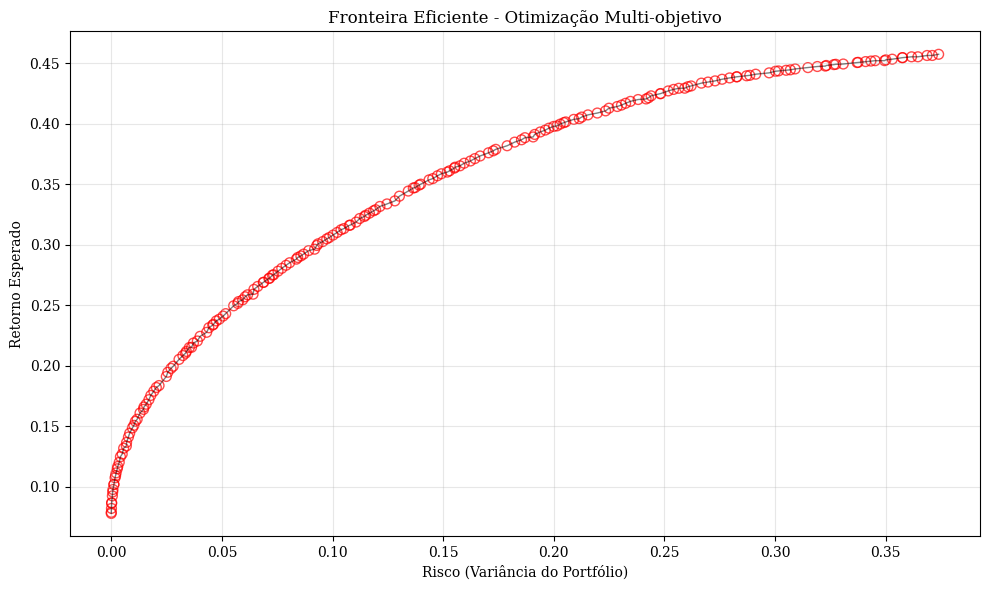

In [84]:
import matplotlib.pyplot as plt

# Transformar os dados
risk = res.F[:, 0]
expected_return = -res.F[:, 1]  # Multiplicar por -1 para obter retorno positivo

# Criar o plot personalizado
plt.figure(figsize=(10, 6))
plt.scatter(risk, expected_return, facecolor="none", edgecolor="red", s=50, alpha=0.7)

# Personalizar labels e título
plt.xlabel('Risco (Variância do Portfólio)')
plt.ylabel('Retorno Esperado')
plt.title('Fronteira Eficiente - Otimização Multi-objetivo')
plt.grid(True, alpha=0.3)

# Destacar a fronteira eficiente
sorted_indices = np.argsort(risk)
plt.plot(risk[sorted_indices], expected_return[sorted_indices], 'k-', alpha=0.5, linewidth=1)

plt.tight_layout()
plt.show()

In [104]:
import matplotlib.pyplot as plt
import numpy as np

# Transformar dados
risk = res.F[:, 0]
expected_return = -res.F[:, 1]

risk_free_rate = 0.0478 + 0.04
sharpe_ratios = (expected_return - risk_free_rate) / np.sqrt(risk)

# Selecionar os 3 portfólios
max_return_idx = np.argmax(expected_return)  # Maior retorno
min_risk_idx = np.argmin(risk)               # Menor risco
print(risk[min_risk_idx])
print(res.X[min_risk_idx])
max_sharpe_idx = np.argmax(sharpe_ratios)    # Maior Sharpe

# Função para mostrar composição do portfólio
def show_portfolio_composition(weights, title, idx):
    tickers = adj_close_df.columns.tolist()
    
    print(f"\n{title}")
    print("=" * 50)
    print(f"Retorno esperado: {expected_return[idx]:.2%}")
    print(f"Risco (volatilidade): {np.sqrt(risk[idx]):.2%}")
    print(f"Sharpe ratio: {sharpe_ratios[idx]:.3f}")
    print("\nComposição do portfólio:")
    
    # Criar lista de (ticker, peso) e ordenar por peso
    portfolio_composition = [(ticker, weight) for ticker, weight in zip(tickers, weights)]
    portfolio_composition.sort(key=lambda x: x[1], reverse=True)
    
    # Mostrar apenas ativos com peso > 0.5%
    significant_assets = [(ticker, weight) for ticker, weight in portfolio_composition if weight > 0.005]
    
    for ticker, weight in significant_assets:
        print(f"  {ticker}: {weight:.2%}")
    
    total_significant = sum(weight for _, weight in significant_assets)
    print(f"\nTotal dos ativos significativos: {total_significant:.2%}")
    
    return significant_assets

# Analisar os 3 portfólios
print("ANÁLISE DOS PORTFÓLIOS SELECIONADOS")
print("=" * 60)

portfolio1 = show_portfolio_composition(res.X[max_return_idx], "PORTFÓLIO DE MAIOR RETORNO", max_return_idx)
portfolio2 = show_portfolio_composition(res.X[min_risk_idx], "PORTFÓLIO DE MENOR RISCO", min_risk_idx)
portfolio3 = show_portfolio_composition(res.X[max_sharpe_idx], "PORTFÓLIO DE MAIOR SHARPE RATIO", max_sharpe_idx)

8.99729047877203e-06
[2.31828180e-05 4.75709203e-07 3.58179617e-06 1.21303611e-05
 3.19046475e-05 1.57433866e-04 3.32769015e-05 1.51125193e-07
 2.09270406e-04 5.53461569e-05 2.96479620e-05 1.15282279e-06
 4.71719663e-05 2.71999332e-05 5.63041078e-06 3.68717988e-06
 7.54259780e-05 2.76449724e-06 4.57164739e-05 3.03405755e-05
 4.18172707e-05 3.04162558e-05 5.63524369e-04 1.13747481e-05
 9.39782128e-01 5.87167879e-02 5.84597545e-05]
ANÁLISE DOS PORTFÓLIOS SELECIONADOS

PORTFÓLIO DE MAIOR RETORNO
Retorno esperado: 45.76%
Risco (volatilidade): 61.15%
Sharpe ratio: 0.605

Composição do portfólio:
  PRIO3: 99.90%

Total dos ativos significativos: 99.90%

PORTFÓLIO DE MENOR RISCO
Retorno esperado: 7.81%
Risco (volatilidade): 0.30%
Sharpe ratio: -3.224

Composição do portfólio:
  IMA-S: 93.98%
  IRFM-1: 5.87%

Total dos ativos significativos: 99.85%

PORTFÓLIO DE MAIOR SHARPE RATIO
Retorno esperado: 35.38%
Risco (volatilidade): 37.90%
Sharpe ratio: 0.702

Composição do portfólio:
  PRIO3: 40.68

In [93]:
teste = sorted(risk)
teste

[np.float64(8.99729047877203e-06),
 np.float64(1.1352659604384064e-05),
 np.float64(9.566205233149575e-05),
 np.float64(0.00016082886483516186),
 np.float64(0.0001846048000848098),
 np.float64(0.0005101923600393879),
 np.float64(0.0006536744214359397),
 np.float64(0.0007700910723243225),
 np.float64(0.0011968470457999025),
 np.float64(0.0012178661679884725),
 np.float64(0.0017183217234071754),
 np.float64(0.001954869813101503),
 np.float64(0.002200817479254638),
 np.float64(0.0027311106400167004),
 np.float64(0.0029345269544475746),
 np.float64(0.0036137655113575684),
 np.float64(0.00413978352454556),
 np.float64(0.004945511022576073),
 np.float64(0.005599104284600581),
 np.float64(0.0068228947004413225),
 np.float64(0.006927263066278257),
 np.float64(0.00776227493686741),
 np.float64(0.008316222592643035),
 np.float64(0.009562434061437862),
 np.float64(0.010236285455888233),
 np.float64(0.010895409796750667),
 np.float64(0.011706386935524494),
 np.float64(0.013005112893320993),
 np.fl

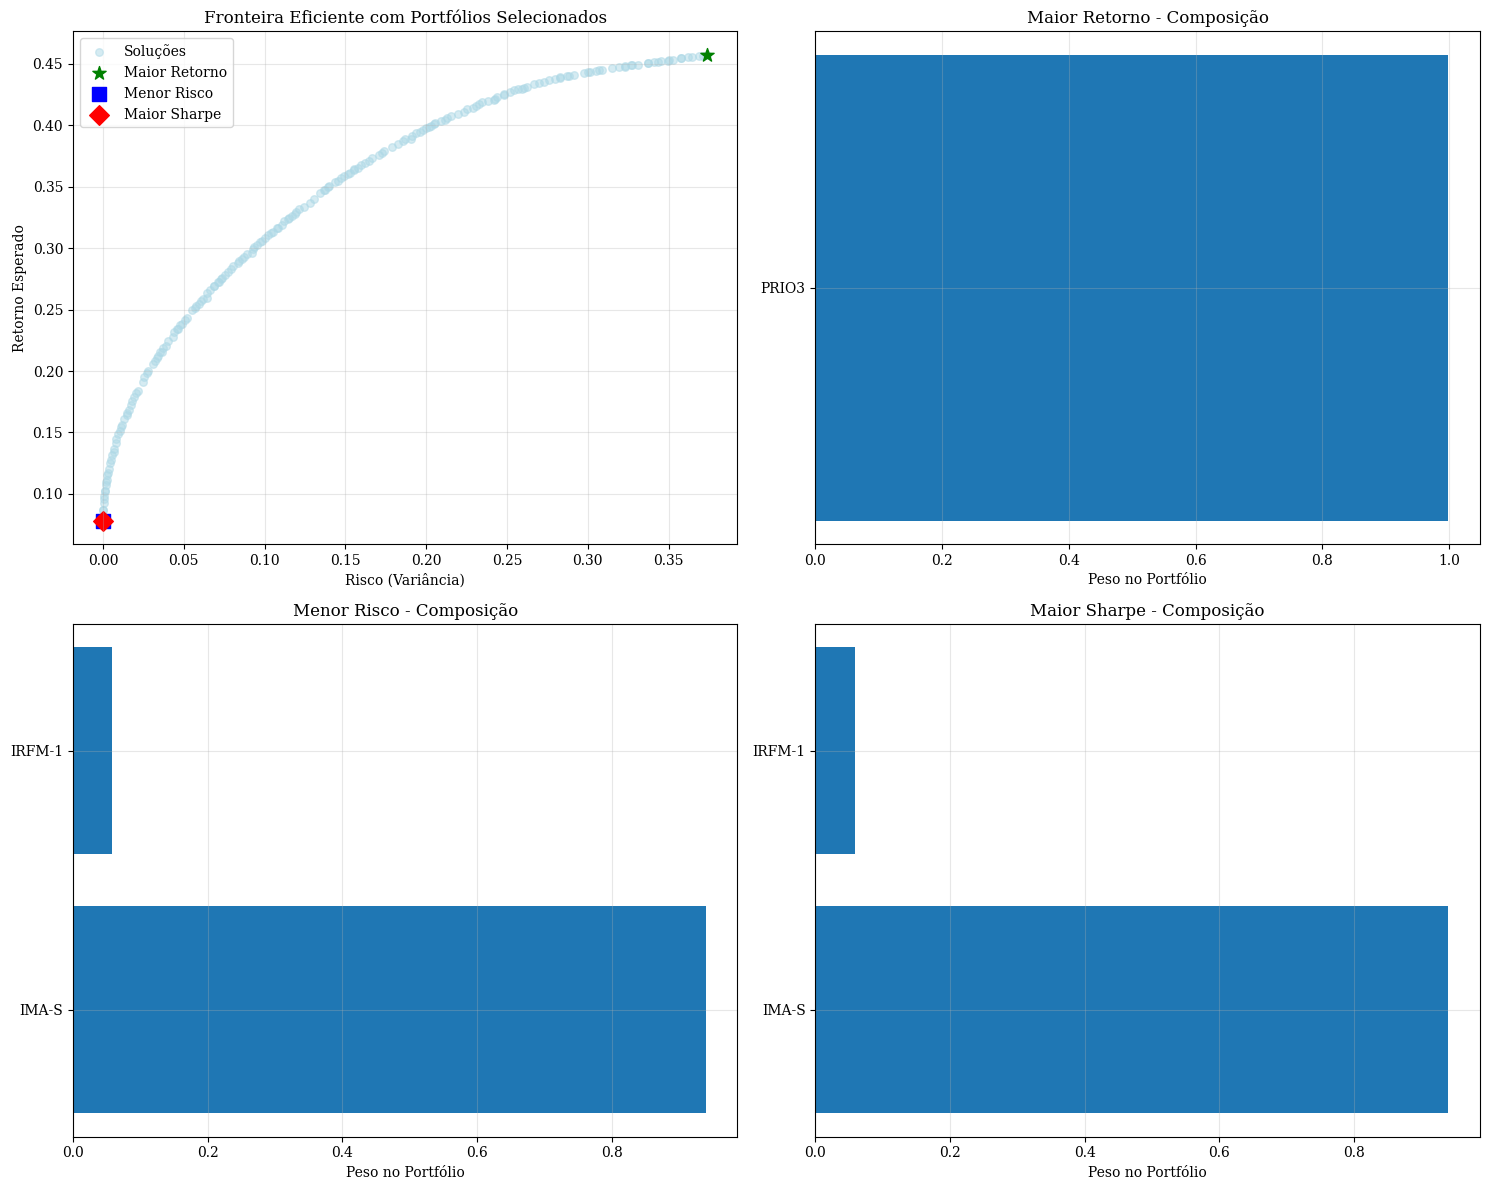

In [86]:
# Visualização comparativa
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))

# Plot 1: Fronteira eficiente com os 3 portfólios destacados
ax1.scatter(risk, expected_return, alpha=0.5, s=30, color='lightblue', label='Soluções')
ax1.scatter(risk[max_return_idx], expected_return[max_return_idx], 
           color='green', s=100, marker='*', label='Maior Retorno')
ax1.scatter(risk[min_risk_idx], expected_return[min_risk_idx], 
           color='blue', s=100, marker='s', label='Menor Risco')
ax1.scatter(risk[max_sharpe_idx], expected_return[max_sharpe_idx], 
           color='red', s=100, marker='D', label='Maior Sharpe')

ax1.set_xlabel('Risco (Variância)')
ax1.set_ylabel('Retorno Esperado')
ax1.set_title('Fronteira Eficiente com Portfólios Selecionados')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot 2: Composição do portfólio de maior retorno
if portfolio1:
    tickers1, weights1 = zip(*portfolio1[:10])  # Top 10
    ax2.barh(range(len(tickers1)), weights1)
    ax2.set_yticks(range(len(tickers1)))
    ax2.set_yticklabels(tickers1)
    ax2.set_xlabel('Peso no Portfólio')
    ax2.set_title('Maior Retorno - Composição')
    ax2.grid(True, alpha=0.3)

# Plot 3: Composição do portfólio de menor risco
if portfolio2:
    tickers2, weights2 = zip(*portfolio2[:10])  # Top 10
    ax3.barh(range(len(tickers2)), weights2)
    ax3.set_yticks(range(len(tickers2)))
    ax3.set_yticklabels(tickers2)
    ax3.set_xlabel('Peso no Portfólio')
    ax3.set_title('Menor Risco - Composição')
    ax3.grid(True, alpha=0.3)

# Plot 4: Composição do portfólio de maior Sharpe
if portfolio3:
    tickers3, weights3 = zip(*portfolio3[:10])  # Top 10
    ax4.barh(range(len(tickers3)), weights3)
    ax4.set_yticks(range(len(tickers3)))
    ax4.set_yticklabels(tickers3)
    ax4.set_xlabel('Peso no Portfólio')
    ax4.set_title('Maior Sharpe - Composição')
    ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [87]:
# Tabela comparativa resumida
import pandas as pd

comparison_data = {
    'Métrica': ['Retorno Esperado', 'Risco (Volatilidade)', 'Sharpe Ratio'],
    'Maior Retorno': [
        f"{expected_return[max_return_idx]:.2%}",
        f"{np.sqrt(risk[max_return_idx]):.2%}",
        f"{sharpe_ratios[max_return_idx]:.3f}"
    ],
    'Menor Risco': [
        f"{expected_return[min_risk_idx]:.2%}",
        f"{np.sqrt(risk[min_risk_idx]):.2%}",
        f"{sharpe_ratios[min_risk_idx]:.3f}"
    ],
    'Maior Sharpe': [
        f"{expected_return[max_sharpe_idx]:.2%}",
        f"{np.sqrt(risk[max_sharpe_idx]):.2%}",
        f"{sharpe_ratios[max_sharpe_idx]:.3f}"
    ]
}

comparison_df = pd.DataFrame(comparison_data)
print("\nTABELA COMPARATIVA DOS PORTFÓLIOS")
print("=" * 60)
print(comparison_df.to_string(index=False))


TABELA COMPARATIVA DOS PORTFÓLIOS
             Métrica Maior Retorno Menor Risco Maior Sharpe
    Retorno Esperado        45.76%       7.81%        7.81%
Risco (Volatilidade)        61.15%       0.30%        0.30%
        Sharpe Ratio         0.716      19.380       19.380



Portfólio com maior Sharpe Ratio e risco > 0:
Risco: 15.54%
Retorno esperado: 36.43%
Sharpe Ratio: 0.873

Composição do portfólio:

PORTFÓLIO SELECIONADO
Retorno esperado: 36.43%
Risco (volatilidade): 39.42%
Sharpe ratio: 0.873

Composição do portfólio:
  PRIO3: 44.50%
  BTC: 24.76%
  BPAC11: 17.07%
  SUZB3: 6.85%
  JBSS3: 6.67%

Total dos ativos significativos: 99.85%


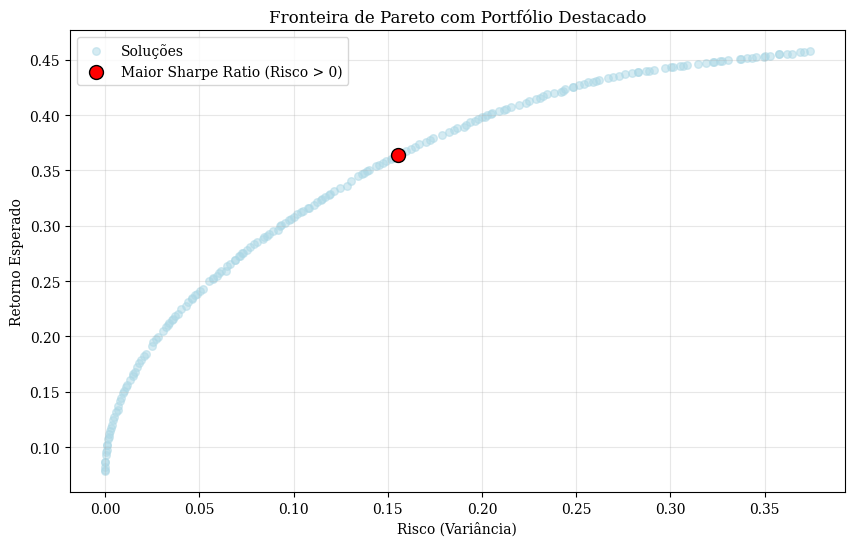


PORTFÓLIO DE MAIOR SHARPE RATIO (RISCO > 0)
Retorno esperado: 36.43%
Risco (volatilidade): 39.42%
Sharpe ratio: 0.873

Composição do portfólio:
  PRIO3: 44.50%
  BTC: 24.76%
  BPAC11: 17.07%
  SUZB3: 6.85%
  JBSS3: 6.67%

Total dos ativos significativos: 99.85%


[('PRIO3', np.float64(0.4449683973341715)),
 ('BTC', np.float64(0.24761960724986928)),
 ('BPAC11', np.float64(0.17068266132111626)),
 ('SUZB3', np.float64(0.06852056470913309)),
 ('JBSS3', np.float64(0.06673132343955254))]

In [102]:
# Filtrar soluções com risco maior que zero
valid_indices = np.where(risk >= 0.15)[0]

if len(valid_indices) == 0:
    print("Nenhuma solução com risco maior que zero encontrada.")
else:
    # Filtrar Sharpe ratios e riscos válidos
    valid_sharpe_ratios = sharpe_ratios[valid_indices]
    valid_risks = risk[valid_indices]
    valid_expected_returns = expected_return[valid_indices]

    # Encontrar o índice do maior Sharpe Ratio entre as soluções válidas
    max_sharpe_idx_in_valid = np.argmax(valid_sharpe_ratios)

    # Obter o índice original da solução no conjunto completo
    max_sharpe_idx = valid_indices[max_sharpe_idx_in_valid]

    # Obter os pesos e métricas do portfólio selecionado
    best_weights = res.X[max_sharpe_idx]
    best_risk = risk[max_sharpe_idx]
    best_return = expected_return[max_sharpe_idx]
    best_sharpe = sharpe_ratios[max_sharpe_idx]

    print("\nPortfólio com maior Sharpe Ratio e risco > 0:")
    print(f"Risco: {best_risk:.2%}")
    print(f"Retorno esperado: {best_return:.2%}")
    print(f"Sharpe Ratio: {best_sharpe:.3f}")
    print("\nComposição do portfólio:")
    show_portfolio_composition(best_weights, "PORTFÓLIO SELECIONADO", max_sharpe_idx)

# Plotar a fronteira de Pareto com o portfólio destacado
plt.figure(figsize=(10, 6))

# Plotar todas as soluções
plt.scatter(risk, expected_return, alpha=0.5, s=30, color='lightblue', label='Soluções')

# Destacar o portfólio com maior Sharpe Ratio e risco > 0
plt.scatter(best_risk, best_return, color='red', s=100, label='Maior Sharpe Ratio (Risco > 0)', edgecolor='black')

# Personalizar o gráfico
plt.xlabel('Risco (Variância)')
plt.ylabel('Retorno Esperado')
plt.title('Fronteira de Pareto com Portfólio Destacado')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Mostrar a composição do portfólio selecionado
show_portfolio_composition(best_weights, "PORTFÓLIO DE MAIOR SHARPE RATIO (RISCO > 0)", max_sharpe_idx)